In [1]:
!pip install pandas_ta
import pandas_ta as ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=a41420789dbefdf2917c4b23783fcdc6a5d1a7e879ca5387d817ac9201658816
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas_ta


In [2]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from keras.initializers import glorot_uniform
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn')
from keras.callbacks import EarlyStopping, LearningRateScheduler
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize, trimboth


Tensorflow version: 2.6.4


In [3]:
batch_size = 32
seq_len = 60

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
#!pip install pandas_ta

In [ ]:
IBM_path = '/kaggle/input/lstmbtcusdt/BTCUSDTlstm.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols= ['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume']
)
df = df.drop(df.index[:50]).drop(df.index[-1])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Time', inplace=True)

# Determine the number of rows per day
#rows_per_day = int(24 * 60 / 1) # assuming 1-hour intervals

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

#Drop the Time column
df.drop(labels=['Time'], axis=1, inplace=True)

#print(df.head())
#print(df.shape)
print(df.columns)

In [4]:
def calculate_moving_average(df, window=20):
    ohlcv_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for column in ohlcv_columns:
        df[column] = df[column].rolling(window=window).mean()
    return df

#df = calculate_moving_average(df)
#print(df)


In [5]:
def drop_zeros(df):
    return df[(df != 0).all(axis=1)]


In [ ]:
df = drop_zeros(df)

In [ ]:
df.dropna(inplace=True)
print(df)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.iloc[:,9:11]

In [5]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
#scaler = StandardScaler()

# Fit the scaler on your data
#scaler.fit(df["Eigenvalues"].tolist() + df["EigenvalueRatios"].tolist())

# Scale the "Eigenvalues" column
#df["Eigenvalues"] = scaler.transform(df["Eigenvalues"].tolist())

# Scale the "EigenvalueRatios" column
#df["EigenvalueRatios"] = scaler.transform(df["EigenvalueRatios"].tolist())
#print(df)

#from joblib import dump

#dump(scaler, 'eigen_predicted.joblib')

In [6]:
def fill_missing_values(df):
    # Forward fill missing values first
    df = df.ffill()

    # Interpolate any remaining missing values using linear interpolation
    df.interpolate(method='linear', inplace=True)

    return df


In [ ]:
#import joblib

# Train the model and obtain the fitted_lambda_dict

# Save the fitted_lambda_dict
#joblib.dump(fitted_lambda_dict, 'fitted_lambda_dict.joblib')


In [7]:
def add_technical_indicators(df):
    # Handle missing values
    df.fillna(method='ffill', inplace=True)
    df.dropna(how='any', axis=0, inplace=True)

    # Calculate RSI
    df['rsi'] = ta.rsi(df['Close'], length=14)

    # Calculate Bollinger Bands
    bb = ta.bbands(df['Close'], length=20, std=2)
    df['bb_upperband'] = bb['BBU_20_2.0']
    df['bb_middleband'] = bb['BBM_20_2.0']
    df['bb_lowerband'] = bb['BBL_20_2.0']

    # Calculate EMA
    df['ema_30'] = ta.ema(df['Close'], length=30)
    df['ema_50'] = ta.ema(df['Close'], length=50)

    # Calculate ADX
    adx = ta.adx(df['High'], df['Low'], df['Close'], length=14)
    df['adx'] = adx['ADX_14']
    df['dmp'] = adx['DMP_14']
    df['dmn'] = adx['DMN_14']

    # Calculate MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['macd'] = macd['MACD_12_26_9']
    df['macd_histogram'] = macd['MACDh_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    
    # Handle missing values introduced by indicator calculations
    df.fillna(method='ffill', inplace=True)
    df.dropna(how='any', axis=0, inplace=True)
    
    # Apply log differencing to numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns
    constant = 1e-6  # A small constant to avoid zero and negative values
    df[numeric_cols] = np.log(df[numeric_cols] + constant).diff().fillna(0)

    
    # Fill NaN values resulting from differencing
    df.fillna(0, inplace=True)
    
    return df


In [ ]:
df = add_technical_indicators(df)
#numeric_cols = df.select_dtypes(include=np.number).columns
#df[numeric_cols] = np.log(df[numeric_cols]).diff()

df.fillna(method='ffill', inplace=True)
df.dropna(how='any', axis=0, inplace=True)
df = fill_missing_values(df)
df.dropna(how='any', axis=0, inplace=True)
#df, fitted_lambda_dict = apply_boxcox_transformation(df)
# Check the descriptive statistics of the DataFrame
print(df.describe())


In [ ]:
df.dropna(inplace=True)
df.columns

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on 'Close' column
adf_result = adfuller(df['Close'])

# Extract the ADF test statistics and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

# Print the results
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)


In [5]:
def data(ds, scaler, seq_len=60):
    X = []
    y = []
    for i in range(seq_len, len(ds) - 1):
        df = ds[i-seq_len:i+1]  # Get the 60-row sequence
        df_scaled = scaler.transform(df)

        X.append(df_scaled[:-1])  # Append all rows except the last one to X
        y.append(df_scaled[-1, 3])  # Append the "Close" column of the last row to y

    return np.array(X), np.array(y)


In [29]:
def data(ds, scaler, seq_len=60, cumulative_steps=[5, 10]):
    X = []
    y = []
    for i in range(seq_len, len(ds)):
        df = ds[i - seq_len:i + 1]  # Get the 60-row sequence
        df_scaled = scaler.transform(df)

        X.append(df_scaled[:-1])  # Append all rows except the last one to X
        
        # Calculate the cumulative change in the "Close" price over specified steps
        cum_changes = []
        for steps in cumulative_steps:
            start_index = i - seq_len
            end_index = i + steps
            cum_change = np.sum(ds[start_index:end_index, 3])
            cum_changes.append(cum_change)
        
        y.append(cum_changes)

    return np.array(X), np.array(y)

In [6]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]


# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

from sklearn.preprocessing import StandardScaler

# Retain columns 9 and 10
#train_cols_9_10 = train_data[:, 9:11]

# Delete columns 9 and 10
#train_data_del = np.delete(train_data, [9, 10], axis=1)
#print(train_data_del.shape)

# Scale the remaining columns
scaler = StandardScaler()
scaler.fit(train_data)



# Training data
X_train, y_train = data(train_data, scaler)

# Validation data
X_val, y_val = data(val_data, scaler)

# Test data
X_test, y_test = data(test_data, scaler)


print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

NameError: name 'df' is not defined

In [21]:
df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,rsi,...,bb_middleband,bb_lowerband,ema_30,ema_50,adx,dmp,dmn,macd,macd_histogram,macd_signal
118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
119,-0.000480,-0.000383,-0.000451,-0.000324,-0.027886,0.196118,0.019803,-0.071832,-0.070692,-0.057998,...,-0.000220,-0.000600,-0.000218,-0.000153,0.019133,-0.059143,0.046618,0.000000,0.000000,0.0
120,-0.000324,-0.000518,-0.000498,-0.000616,0.013630,0.473478,0.183138,-0.084861,-0.084486,-0.109010,...,-0.000262,-0.000650,-0.000244,-0.000171,0.018989,-0.059763,0.052858,0.000000,0.000000,0.0
121,-0.000616,-0.000581,-0.000548,-0.000543,-0.003332,-0.493068,-0.116763,0.105428,0.103239,-0.093552,...,-0.000293,-0.000671,-0.000263,-0.000186,0.018759,-0.060208,0.058617,0.000000,0.000000,0.0
122,-0.000543,-0.000572,-0.000479,-0.000673,-0.007034,0.290537,-0.018519,-0.155427,-0.156957,-0.112481,...,-0.000330,-0.000715,-0.000289,-0.000205,0.018165,-0.059978,0.040139,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143135,0.000120,0.000062,0.000153,0.000235,-0.048512,-0.045093,-0.187808,0.224399,0.225695,0.132273,...,-0.000071,0.000035,-0.000006,-0.000033,-0.000150,0.013979,-0.069783,0.000000,0.000000,0.0
143136,0.000235,0.000190,0.000253,0.000168,-0.054627,-0.010422,0.163602,-0.272813,-0.272222,0.075835,...,-0.000060,0.000067,0.000005,-0.000025,-0.029819,0.165078,-0.068424,0.000000,0.000000,0.0
143137,0.000168,0.000144,0.000131,0.000187,0.024014,0.828491,0.576912,0.918294,0.918786,0.071662,...,-0.000047,0.000091,0.000017,-0.000016,-0.050374,0.088391,-0.069170,0.000000,0.000000,0.0
143138,0.000187,0.000438,0.000348,0.000509,0.114138,0.844741,0.672290,0.935604,0.939078,0.139429,...,-0.000010,0.000031,0.000049,0.000004,-0.040301,0.318123,-0.071937,0.000000,2.206148,0.0


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
import os
from sklearn.utils import resample

# Define a function for preprocessing a single cryptocurrency pair
def preprocess_pair(df):
    times = sorted(df.index.values)
    last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

    ###############################################################################
    '''Create training, validation and test split'''

    df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
    df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
    df_test = df[(df.index >= last_10pct)]


    # Convert pandas columns into arrays
    train_data = df_train.values
    val_data = df_val.values
    test_data = df_test.values


    # Scale the remaining columns
    scaler = StandardScaler()
    scaler.fit(train_data)

    # Training data
    X_train, y_train = data(train_data, scaler)
    print(y_train)

    # Validation data
    X_val, y_val = data(val_data, scaler)

    # Test data
    X_test, y_test = data(test_data, scaler)
    
    # Store the scaler for the current asset pair
    scalers[pair] = scaler

    # Save the scaler for the current asset pair
    scaler_filename = 'scaler_' + pair + '.joblib'
    joblib.dump(scaler, os.path.join(scaler_dir, scaler_filename))

    return X_train, y_train, X_val, y_val, X_test, y_test

# List of cryptocurrency pairs
#pairs = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'DOGEUSDT', 'SOLUSDT', 'BCHUSDT', 'LINKUSDT', 'XRPUSDT']

pairs = ['BTCUSDT']
# Create directory to store scalers if it doesn't exist
scaler_dir = 'scalers'
os.makedirs(scaler_dir, exist_ok=True)

# Load and preprocess the DataFrames separately
scalers = {}

X_train_scaled = []
y_train_scaled = []
X_val_scaled = []
y_val_scaled = []
X_test_scaled = []
y_test_scaled = []

# Iterate through cryptocurrency pairs
for pair in pairs:
    filename = '/kaggle/input/data-archive/' + pair + '.csv'
    df = pd.read_csv(filename, delimiter=',', usecols= ['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume']
)
    df = df.drop(df.index[:50]).drop(df.index[-1])

    # Replace 0 to avoid dividing by 0 later on
    df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
    df.sort_values('Time', inplace=True)

    # Determine the number of rows per day
    #rows_per_day = int(24 * 60 / 1) # assuming 1-hour intervals

    # Drop all rows with NaN values
    df.dropna(how='any', axis=0, inplace=True) 

    #Drop the Time column
    df.drop(labels=['Time'], axis=1, inplace=True)
    df = calculate_moving_average(df)
    df = add_technical_indicators(df)

    df.fillna(method='ffill', inplace=True)
    df.dropna(how='any', axis=0, inplace=True)
    df = fill_missing_values(df)
    df.dropna(how='any', axis=0, inplace=True)
    
    
    X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq = preprocess_pair(df)

    # Store the scaled and sequenced data
    X_train_scaled.extend(X_train_seq)
    y_train_scaled.extend(y_train_seq)
    X_val_scaled.extend(X_val_seq)
    y_val_scaled.extend(y_val_seq)
    X_test_scaled.extend(X_test_seq)
    y_test_scaled.extend(y_test_seq)

# Convert lists to NumPy arrays
X_train_scaled_combined = np.array(X_train_scaled)
y_train_scaled_combined = np.array(y_train_scaled)
X_val_scaled_combined = np.array(X_val_scaled)
y_val_scaled_combined = np.array(y_val_scaled)
X_test_scaled_combined = np.array(X_test_scaled)
y_test_scaled_combined = np.array(y_test_scaled)

# Print the shapes of the combined scaled and sequenced datasets
print('Training set shape:', X_train_scaled_combined.shape, y_train_scaled_combined.shape)
print('Validation set shape:', X_val_scaled_combined.shape, y_val_scaled_combined.shape)
print('Test set shape:', X_test_scaled_combined.shape, y_test_scaled_combined.shape)

[[-0.006405   -0.0073196 ]
 [-0.00663878 -0.00746225]
 [-0.00721973 -0.00777438]
 ...
 [ 0.07256562  0.07256562]
 [ 0.07054031  0.07054031]
 [ 0.0682516   0.0682516 ]]
Training set shape: (120470, 60, 21) (120470, 2)
Validation set shape: (15006, 60, 21) (15006, 2)
Test set shape: (15006, 60, 21) (15006, 2)


In [31]:
def assign_labels(cumulative_changes):
    labels = np.zeros((cumulative_changes.shape[0], 3))  # Initialize labels array
    
    # Iterate over each row of cumulative changes
    for i, (change1, change2) in enumerate(cumulative_changes):
        if change2 < change1 and change2 < 0:  # If second change is smaller than the first and negative
            labels[i, 1] = 1  # Label as bearish
        elif change2 > change1 and change2 > 0:  # If second change is greater than the first and positive
            labels[i, 2] = 1  # Label as bullish
        else:
            labels[i, 0] = 1  # Label as natural
        
    return labels


y_train_scaled_combined = assign_labels(y_train_scaled_combined)
y_val_scaled_combined = assign_labels(y_val_scaled_combined)
y_test_scaled_combined = assign_labels(y_test_scaled_combined)



In [ ]:
X_train = X_train_scaled_combined 
y_train = y_train_scaled_combined
X_val = X_val_scaled_combined 
y_val = y_val_scaled_combined 
X_test = X_test_scaled_combined 
y_test = y_test_scaled_combined

In [9]:
save_path = '/kaggle/working/combined_dataa.npz'
np.savez(save_path,
         X_train_scaled_combined=X_train_scaled_combined,
         y_train_scaled_combined=y_train_scaled_combined,
         X_val_scaled_combined=X_val_scaled_combined,
         y_val_scaled_combined=y_val_scaled_combined,
         X_test_scaled_combined=X_test_scaled_combined,
         y_test_scaled_combined=y_test_scaled_combined)

print('Data saved to', save_path)

Data saved to /kaggle/working/combined_dataa.npz


In [6]:
import numpy as np

# Create memory-mapped files for your datasets
X_train_scaled_combined = np.memmap('X_train_scaled_combined.dat', dtype='float32', mode='w+', shape=(866741, 60, 21))
y_train_scaled_combined = np.memmap('y_train_scaled_combined.dat', dtype='float32', mode='w+', shape=(866741,))
X_val_scaled_combined = np.memmap('X_val_scaled_combined.dat', dtype='float32', mode='w+', shape=(107915, 60, 21))
y_val_scaled_combined = np.memmap('y_val_scaled_combined.dat', dtype='float32', mode='w+', shape=(107915,))
X_test_scaled_combined = np.memmap('X_test_scaled_combined.dat', dtype='float32', mode='w+', shape=(107913, 60, 21))
y_test_scaled_combined = np.memmap('y_test_scaled_combined.dat', dtype='float32', mode='w+', shape=(107913,))


In [7]:
# Load the combined datasets from the file into the same variable names
save_path = '/kaggle/input/datasetzip/combined_dataa.npz'
loaded_data = np.load(save_path)
# Load the data into memory-mapped arrays
X_train_scaled_combined[:] = loaded_data['X_train_scaled_combined']
y_train_scaled_combined[:] = loaded_data['y_train_scaled_combined']
X_val_scaled_combined[:] = loaded_data['X_val_scaled_combined']
y_val_scaled_combined[:] = loaded_data['y_val_scaled_combined']
X_test_scaled_combined[:] = loaded_data['X_test_scaled_combined']
y_test_scaled_combined[:] = loaded_data['y_test_scaled_combined']


# Print the shapes of the loaded datasets
print('Loaded Training set shape:', X_train_scaled_combined.shape, y_train_scaled_combined.shape)
print('Loaded Validation set shape:', X_val_scaled_combined.shape, y_val_scaled_combined.shape)
print('Loaded Test set shape:', X_test_scaled_combined.shape, y_test_scaled_combined.shape)

Loaded Training set shape: (866741, 60, 21) (866741,)
Loaded Validation set shape: (107915, 60, 21) (107915,)
Loaded Test set shape: (107913, 60, 21) (107913,)


In [9]:
from joblib import dump

dump(scaler, 'train_scalers_predicted.joblib')

NameError: name 'scaler' is not defined

In [11]:
import tensorflow as tf
@tf.autograph.experimental.do_not_convert
def lr_scheduler(epoch, lr, warmup_epochs=10, decay_epochs1=20, decay_epochs2=30, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch <= warmup_epochs + decay_epochs1:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs1)
        return ((base_lr - min_lr) * pct) + min_lr
    
    if epoch > warmup_epochs + decay_epochs1 and epoch <= warmup_epochs + decay_epochs2:
        pct = 1 - ((epoch - warmup_epochs - decay_epochs1) / (decay_epochs2 - decay_epochs1))
        return ((base_lr/10 - min_lr) * pct) + min_lr
    
    return min_lr


In [9]:
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import Callback

class R2Callback(Callback):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if epoch % 10 == 0:  # Print R2 score every 5th epoch
            y_pred = self.model.predict(self.X)
            r2 = r2_score(self.y, y_pred)
            logs['r2'] = r2
            print(f"val_r2: {r2:.4f}")



In [10]:
from keras.regularizers import l2
import tensorflow as tf
import numpy as np

class MyModel(tf.keras.Model):
    def __init__(self, input_shape, num_layers, d_model, num_heads, dff, dropout_rate, l2_reg):
        super(MyModel, self).__init__()
        self.num_layers = num_layers
        self.l2_reg = l2_reg
        self.d_model = d_model

        self.embedding = tf.keras.layers.Dense(d_model, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.pos_encoding = self.positional_encoding(input_shape[0], d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.transformer_blocks = [self.transformer_block(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.lstm = tf.keras.layers.LSTM(d_model, return_sequences=True)
        self.attention = tf.keras.layers.Attention()
        self.fc = tf.keras.layers.Dense(d_model, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.final_layer = tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    def call(self, inputs):
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :tf.shape(x)[1], :]
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.transformer_blocks[i](x)
        x = self.lstm(x)
        x = self.attention([x, x])
        x = self.fc(x)
        x = self.final_layer(x[:, -1, :])
        return x

    def transformer_block(self, d_model, num_heads, dff, dropout_rate):
        inputs = tf.keras.Input(shape=(None, d_model))
        attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
        attn = tf.keras.layers.Dropout(dropout_rate)(attn)
        out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn)

        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg)),
            tf.keras.layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg))
        ])
        ffn_output = ffn(out1)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
        out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
        return tf.keras.Model(inputs=inputs, outputs=out2)

    def get_angles(self, pos, i):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(self.d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :])
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.constant(pos_encoding, dtype=tf.float32)


# Define the model
#model = MyModel((X_train.shape[1],), num_layers=4, d_model=128, num_heads=8, dff=512, dropout_rate=0.2)

# Compile the model
#model.compile(loss='mean_squared_error', optimizer='adam')


# Train the model
#history = model.fit(X_train, y_train, batch_size=1024, epochs=30, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=3, restore_best_weights=True), LearningRateScheduler(lr_scheduler), R2Callback(X_train, y_train)])

# Evaluate the model on test data
#test_loss = model.evaluate(X_test, y_test)
#test_r2 = r2_score(y_test, model.predict(X_test))
#print("Test loss: {:.4f}".format(test_loss))
#print("Test R2 score: {:.4f}".format(test_r2))


In [23]:
print(len(X_train_scaled_combined))
print(len(y_train_scaled_combined))

120470
120470


In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from keras.wrappers.scikit_learn import KerasRegressor

# Create a function to build the model
def build_model(num_layers, d_model, num_heads, dff, dropout_rate, l2_reg):
    model = MyModel((X_train_scaled_combined.shape[1],), num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, l2_reg=l2_reg)
    model.compile(loss='', optimizer='adam')
    return model

# Create the KerasRegressor wrapper
model = KerasRegressor(build_fn=build_model, verbose=1)
# Create the parameter distribution
param_dist = {
    'num_layers': sp_randint(2, 5),    # Lowered lower bound
    'd_model': sp_randint(64, 160),    # Lowered lower bound
    'num_heads': sp_randint(3, 9),     # Lowered lower bound
    'dff': sp_randint(256, 480),       # Lowered lower bound
    'dropout_rate': [0.05, 0.1, 0.2],  # A few options
    'l2_reg': [0.01, 0.05, 0.1]        # A few options
}



# Create the randomized search object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring='neg_mean_squared_error', cv=3, n_iter=10)


# Select a subset of data
subset_size = 500  # Adjust the subset size as needed
X_train_subset = X_train_scaled_combined[:subset_size]
y_train_subset = y_train_scaled_combined[:subset_size]


# Perform randomized search
#random_search.fit(X_train_subset, y_train_subset)  # X_train and y_train are your training data

# Print the best hyperparameters and corresponding mean squared error
#print("Best parameters: ", random_search.best_params_)
#print("Best mean squared error: ", np.sqrt(-random_search.best_score_))

# Get the best model
#best_model = random_search.best_estimator_

# Perform continuous optimization
#history = best_model.fit(X_train, y_train, batch_size=1024, epochs=30, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=3, restore_best_weights=True), LearningRateScheduler(lr_scheduler), R2Callback(X_train, y_train)])


In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

class MyModel(tf.keras.Model):
    def __init__(self, input_shape, num_layers, d_model, num_heads, dff, dropout_rate, l2_reg):
        super(MyModel, self).__init__()
        self.num_layers = num_layers
        self.l2_reg = l2_reg
        self.d_model = d_model

        self.embedding = tf.keras.layers.Dense(d_model, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.pos_encoding = self.positional_encoding(input_shape[0], d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.transformer_blocks = [self.transformer_block(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.lstm = tf.keras.layers.LSTM(d_model, return_sequences=True)
        self.attention = tf.keras.layers.Attention()
        self.fc = tf.keras.layers.Dense(d_model, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.final_layer = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    def call(self, inputs):
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :tf.shape(x)[1], :]
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.transformer_blocks[i](x)
        x = self.lstm(x)
        x = self.attention([x, x])
        x = self.fc(x)
        x = self.final_layer(x[:, -1, :])
        return x

    def transformer_block(self, d_model, num_heads, dff, dropout_rate):
        inputs = tf.keras.Input(shape=(None, d_model))
        attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
        attn = tf.keras.layers.Dropout(dropout_rate)(attn)
        out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn)

        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg)),
            tf.keras.layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg))
        ])
        ffn_output = ffn(out1)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
        out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
        return tf.keras.Model(inputs=inputs, outputs=out2)

    def get_angles(self, pos, i):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(self.d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :])
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.constant(pos_encoding, dtype=tf.float32)


# Define a TensorBoard callback with Kaggle's log directory
tensorboard_callback = TensorBoard(log_dir='/kaggle/working/logs', histogram_freq=1)

# Define the MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

def build_model(num_layers, d_model, num_heads, dff, dropout_rate, l2_reg):
    model = MyModel((X_train_scaled_combined.shape[1],), num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, l2_reg=l2_reg)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

params = {'d_model': 112, 'dff': 397, 'dropout_rate': 0.2, 'l2_reg': 0.01, 'num_heads': 8, 'num_layers': 3}
#params = random_search.best_params_

with strategy.scope():
    best_model = build_model(**params)
    history = best_model.fit(X_train_scaled_combined, y_train_scaled_combined, batch_size=1024, epochs=200, validation_data=(X_val_scaled_combined, y_val_scaled_combined), callbacks=[EarlyStopping(patience=10, restore_best_weights=True), LearningRateScheduler(lr_scheduler),tensorboard_callback])


Epoch 1/200
118/118 [==============================] - 49s 322ms/step - loss: 13.0854 - val_loss: 13.0471
Epoch 2/200
118/118 [==============================] - 33s 277ms/step - loss: 11.2498 - val_loss: 9.7696
Epoch 3/200
118/118 [==============================] - 32s 275ms/step - loss: 7.7839 - val_loss: 6.0755
Epoch 4/200
118/118 [==============================] - 33s 277ms/step - loss: 4.4895 - val_loss: 3.2224
Epoch 5/200
118/118 [==============================] - 33s 277ms/step - loss: 2.3268 - val_loss: 1.6580
Epoch 6/200
118/118 [==============================] - 33s 276ms/step - loss: 1.2855 - val_loss: 1.0150
Epoch 7/200
118/118 [==============================] - 33s 276ms/step - loss: 0.8909 - val_loss: 0.8326
Epoch 8/200
118/118 [==============================] - 33s 277ms/step - loss: 0.7560 - val_loss: 0.7149
Epoch 9/200
118/118 [==============================] - 33s 278ms/step - loss: 0.7062 - val_loss: 0.7194
Epoch 10/200
118/118 [==============================] - 33s 2

In [43]:
#x_train = X_train_scaled_combined[:]
#ghghghghghghghghghgh
print(y_train_scaled_combined)
print("Shape of y_train_scaled_combined:", y_train_scaled_combined.shape)


[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Shape of y_train_scaled_combined: (120470, 3)


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.set_visible_devices


In [ ]:
#ghghghghghghghghghghghghghghghghghghghghghghgh
import tensorflow as tf
from keras import backend as K

# TensorFlow
tf.keras.backend.clear_session()

# Keras
K.clear_session()


In [35]:
# Save the best model
from tensorflow.keras.models import save_model
#ghghghghghghghghghghghghghghghghghghghghghghghghghghghghghghghghgh

# Save the best model
best_model.save('/kaggle/working/model')


In [ ]:
#!pip install keras --upgrade
#ghghghgh
#Best parameters:  {'d_model': 76, 'dff': 629, 'dropout_rate': 0.1, 'l2_reg': 0.01, 'num_heads': 7, 'num_layers': 5}
#Best mean squared error:  0.3272984077979012

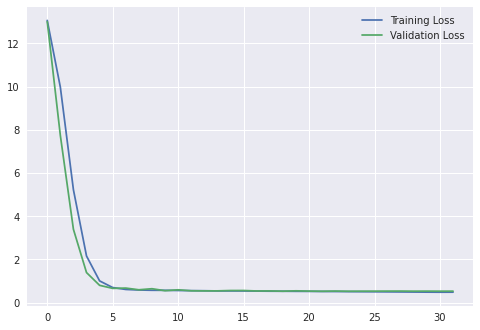

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
#training loss in blue and the validation loss in orange
#If the training loss is much lower than the validation loss, your model is likely overfitting. 
#If both the training and validation loss are high, your model is likely underfitting.

In [ ]:
model = load_model('/kaggle/input/modell/accur')

In [37]:
#model.save('/kaggle/working/accur', save_format='tf')
!zip -r folder2.zip /kaggle/working/model//

  adding: kaggle/working/model// (stored 0%)
  adding: kaggle/working/model//keras_metadata.pb (deflated 94%)
  adding: kaggle/working/model//variables/ (stored 0%)
  adding: kaggle/working/model//variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/model//variables/variables.index (deflated 76%)
  adding: kaggle/working/model//assets/ (stored 0%)
  adding: kaggle/working/model//saved_model.pb (deflated 88%)


In [33]:
#y_test_scaled_combined = assign_labels(y_test_scaled_combined)
y_test_pred = best_model.predict(X_test_scaled_combined)

In [34]:
import numpy as np

# Convert one-hot encoded true labels to class labels
y_test_true_labels = np.argmax(y_test_scaled_combined, axis=1)

# Convert one-hot encoded predictions to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate accuracy
accuracy = np.mean(y_test_pred_labels == y_test_true_labels)
print("Out of Sample Accuracy:", accuracy)


Out of Sample Accuracy: 0.7042516326802613


In [ ]:
# Example of reshaping a 2D array to 1D
y_train_scaled_combined_1d = y_train_scaled_combined.ravel()
y_train_pred_1d = y_train_pred.ravel()

# Create the DataFrame
df = pd.DataFrame({'y_true': y_train_scaled_combined_1d, 'y_pred': y_train_pred_1d})

In [ ]:
df.to_csv('predictions.csv', index=False)

In [ ]:
# Make predictions on the training, validation, and test sets
#y_train_pred = model.predict(X_train_scaled_combined)
y_val_pred = model.predict(X_val_scaled_combined)
y_test_pred = model.predict(X_test_scaled_combined)

# Plot the actual vs predicted values for the training set
#plt.figure(figsize=(32, 16))
#plt.plot(y_train_scaled_combined, label='Actual')
#plt.plot(y_train_pred, label='Predicted')
#plt.title('Training Set')
#plt.legend()
#plt.show()

# Plot the actual vs predicted values for the validation set
plt.figure(figsize=(32, 16))
plt.plot(y_val_scaled_combined, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.title('Validation Set')
plt.legend()
plt.show()

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(32, 16))
plt.plot(y_test_scaled_combined, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Test Set')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
y_test_pred = model.predict(X_test_scaled_combined)
# Calculate R2 score for the test setgh
r2 = r2_score(y_test_scaled_combined, y_test_pred)
print("R2 Score:", r2)

In [ ]:
model = best_model